# This notebook provides example of the steps to plant SNe around a lensing galaxy

In [1]:
import astropy
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from astropy.stats import sigma_clipped_stats,gaussian_fwhm_to_sigma,gaussian_sigma_to_fwhm
from astropy.table import Table,Column,Row,vstack,setdiff,join
from astropy.nddata import Cutout2D,NDData
import astropy.units as u
import os 
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval,simple_norm
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord

import photutils
from photutils.datasets import make_gaussian_sources_image

import numpy as np
import itertools
import copy

import matplotlib
from astropy.visualization import ZScaleInterval,simple_norm
zscale = ZScaleInterval()
import pickle
import numpy as np

In [1]:
import diffimageml

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [1]:
import fakeplanting
import util
import figures

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


# Initialize the FakePlanter Class with test data

In [2]:
# get one of the two test data-sets provided
if True:
    diffim_fitsfilename = "test_data/diff_pydia_1.fits.fz"
    searchim_fitsfilename = "test_data/sky_image_1.fits.fz"
    templateim_fitsfilename = "test_data/template_1.fits.fz"
else:
    diffim_fitsfilename = "test_data/diff_pydia_2.fits.fz"
    searchim_fitsfilename = "test_data/sky_image_2.fits.fz"
    templateim_fitsfilename = "test_data/template_2.fits.fz"

# initialize the FakePlanter Class 
fp = fakeplanting.FakePlanter(diffim_fitsfilename,
                          searchim_fitsfilename=searchim_fitsfilename,
                          templateim_fitsfilename=templateim_fitsfilename)

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


# Detecting galaxies
## Selecting one for use with example in this nb 

In [7]:
# Galaxies are identified using cuts on ellipticity/area to remove stars/cosmic rays from detected sources
fp.has_detections = False
fp.templateim.detect_host_galaxies(ellipticity_cut = 0.35 , cut_cr = True, edges = True, nsigma=10)
print("{} galaxies detected in the template".format(len(fp.templateim.hostgalaxies)))

print("For purpose of displaying positions (phi,d) for planting fakes around lensing host, selecting the first galaxy") 
galaxy_idx = 0
host = fp.templateim.hostgalaxies[galaxy_idx]
host["Source Properties"].to_table()

14 galaxies detected in the template
For purpose of displaying positions (phi,d) for planting fakes around lensing host, selecting the first galaxy


id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,orientation,eccentricity,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy,gini
,pix,pix,,,,,,,,pix,pix,pix,pix,,,pix,pix,pix,pix,pix2,pix,pix,pix,pix,deg,,,,pix2,pix2,pix2,1 / pix2,1 / pix2,1 / pix2,
int64,float64,float64,object,object,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
18,1451.7765800512723,237.56387965912907,None,None,796.417938891407,None,6505.834693151423,361.43526073063464,361.4352063751844,1449.0,1454.0,236.0,239.0,37.773806987282285,52.79837231592393,1452.0,236.0,1453.0,238.0,18.0,2.393653682408596,13.65685424949238,1.5272834622472333,0.8941487972435961,21.132286475561617,0.8107081874714659,0.4145495454210233,1.7080864694505093,2.1333288192139355,0.5155446250829746,0.9987680264521299,0.5355570481094074,-0.5528882588660692,1.1439285748097612,0.050181952713786296


# Creating lensed locations around the galaxy

In [8]:
# quad imaged SN
phi_deg = [45,-45,135,-135]
d_pix = [10,10,10,10]
fluxes = [2*10**3,3*10**3,4*10**3,5*10**3]
galaxy_indices = [galaxy_idx for i in range(len(phi_deg))]

print("Setting four locations around the galaxy (all of similar flux will be easily detectable)")

fake_positions_and_fluxes = fp.set_fake_positions_at_galaxies(phi_deg,d_pix,fluxes=fluxes,galaxy_indices=galaxy_indices)
print(fp.templateim.lensed_locations.meta)
fp.templateim.lensed_locations

Setting four locations around the galaxy (all of similar flux will be easily detectable)
{'phi_deg': [45, -45, 135, -135], 'd_pix': [10, 10, 10, 10], 'galaxy_indices': [0, 0, 0, 0], 'delta_x': <Quantity [ 4.04626336,  9.14482109, -9.14482109, -4.04626336]>, 'delta_y': <Quantity [ 9.14482109, -4.04626336,  4.04626336, -9.14482109]>}


x_fit,y_fit,flux_fit
,,
float64,float64,int64
1455.8228434065886,246.70870075412182,2000
1460.921401146265,233.51761630381276,3000
1442.6317589562796,241.61014301444538,4000
1447.730316695956,228.41905856413632,5000


# Visualize the galaxy ellipse and lensed locations around it

Theta (orientation from source_properties) is direction of the galaxy semimajor axis a, CCW with respect to +x
Phi is CCW with respect to the semimajor axis
d is pixels from galaxy centroid


Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


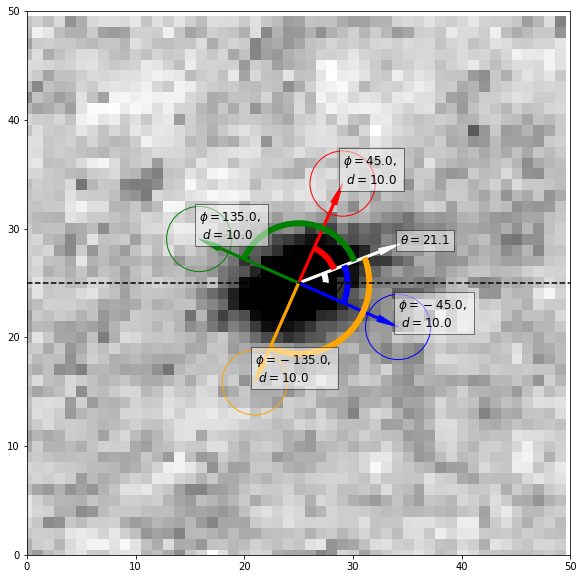

In [9]:
print("Theta (orientation from source_properties) is direction of the galaxy semimajor axis a, CCW with respect to +x")
print("Phi is CCW with respect to the semimajor axis")
print("d is pixels from galaxy centroid")

fp.plot_lensed_locations()

# plant SNe in at the locations
## see example nb "" for details of building the epsf
## just taking available ePSF in test_data

In [10]:
import pickle
build_epsf = pickle.load(open("test_data/sky_image_1_TestEPSFModel.pkl","rb"))

# Plant the fakes
fp.plant_fakes_triplet(
    fake_positions_and_fluxes, psfmodel=build_epsf,
    writetodisk=False, save_suffix="planted.fits",preserve_original=False)

print("Fake planting is done.")
assert(fp.diffim.has_fakes==True)
assert(fp.searchim.has_fakes==True)
print("has_fakes is True, True!")

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Fake planting is done.
has_fakes is True, True!


# Display the fakes in the diff image

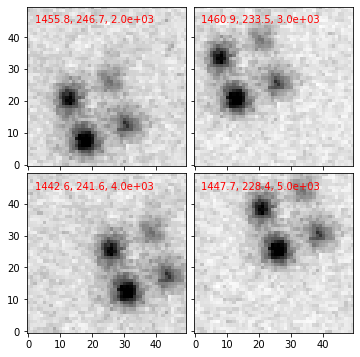

In [12]:
# fake_indices is the SN FKNNN that you want to plot
# in this ex: we used a quad multiply imaged by single lens, so they are all visible around one another  
fake_indices=[0,1,2,3]
fp.plot_fakes(
    fake_indices=fake_indices)

In [13]:
MEFS = fp.plants_MEF(fake_indices,cutoutsize=50,writetodisk=False,saveas='test.fits')

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 fro